# AN2DL - Homework 1

## 1 - Libraries and Dataset Import


In [ ]:
# In this notebook you will only find comments related to new/modified code
# Please refere to our initial notebook FORmidable_basic_model for all commented sections
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import cv2
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras import applications as tfka
from keras_cv import layers as kcvl
from keras import mixed_precision

tf.config.optimizer.set_jit(True)

print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(f"TensorFlow version {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

c:\Users\teopo\Desktop\ANNLabs\HOM1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPUs Available:  []
TensorFlow version 2.17.0


In [ ]:
data = np.load('training_set.npz')

X = data['images']
y = data['labels']
print(X.shape, y.shape)

(13759, 96, 96, 3) (13759, 1)


## 2 - Checking for missing, duplicate values and class distribution

In [3]:
missing_targets = np.isnan(y.flatten()).any()

if not missing_targets :
    print("There are no missing or NaN values in the target vector.")

There are no missing or NaN values in the target vector.


In [ ]:
# Duplicates count and removal
reshaped_X = X.reshape(X.shape[0], -1)
unique_X, unique_indices = np.unique(reshaped_X, axis=0, return_index=True)

X_unique = X[unique_indices]
y_unique = y[unique_indices]

print(f'Labels reduced from {len(y)} to {len(y_unique)}')

X = X_unique
y = y_unique

Labels reduced from 13759 to 11953


In [ ]:
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Class plotting already shown in FORmidable_basic_model notebook
''''''

"\n# Save unique labels\nunique_labels = list(labels.values())\n\n# Display a sample of images from the training-validation dataset\nnum_img = 10\nrandom_indices = random.sample(range(len(X)), num_img)\n\nfig, axes = plt.subplots(1, num_img, figsize=(20, 20))\n\n# Iterate through the selected number of images\nfor i, idx in enumerate(random_indices):\n    ax = axes[i % num_img]\n    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)\n    ax.set_title(f'{labels[y[idx][0]]}')\n    ax.axis('off')\n\n# Adjust layout and display the images\nplt.tight_layout()\nplt.show()\n\nlabels_list, counts = np.unique(y.flatten(), return_counts=True)\nclasses = [labels[label] for label in labels_list]\ndf = pd.DataFrame({'Class': classes, 'Count': counts})\n\n# Plot the barplot\nplt.figure(figsize=(10, 6))\nsns.barplot(x=classes, y=counts)\nplt.title('Class distribution in the Dataset')\nplt.xlabel('Class')\nplt.ylabel('Count')\nplt.xticks(rotation=45)  # Adjust rotation for readability if needed\nplt.show

## 3 - Split dataset into Train, Test and Validation sets while maintaining the distribution

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

Training Data Shape: (8605, 96, 96, 3)
Training Label Shape: (8605, 1)
Test Data Shape: (2391, 96, 96, 3)
Test Label Shape: (2391, 1)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 1)


## 4 - Image Augmentation

I0000 00:00:1732225290.619044   89758 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732225290.623154   89758 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732225290.626512   89758 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732225290.758535   89758 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

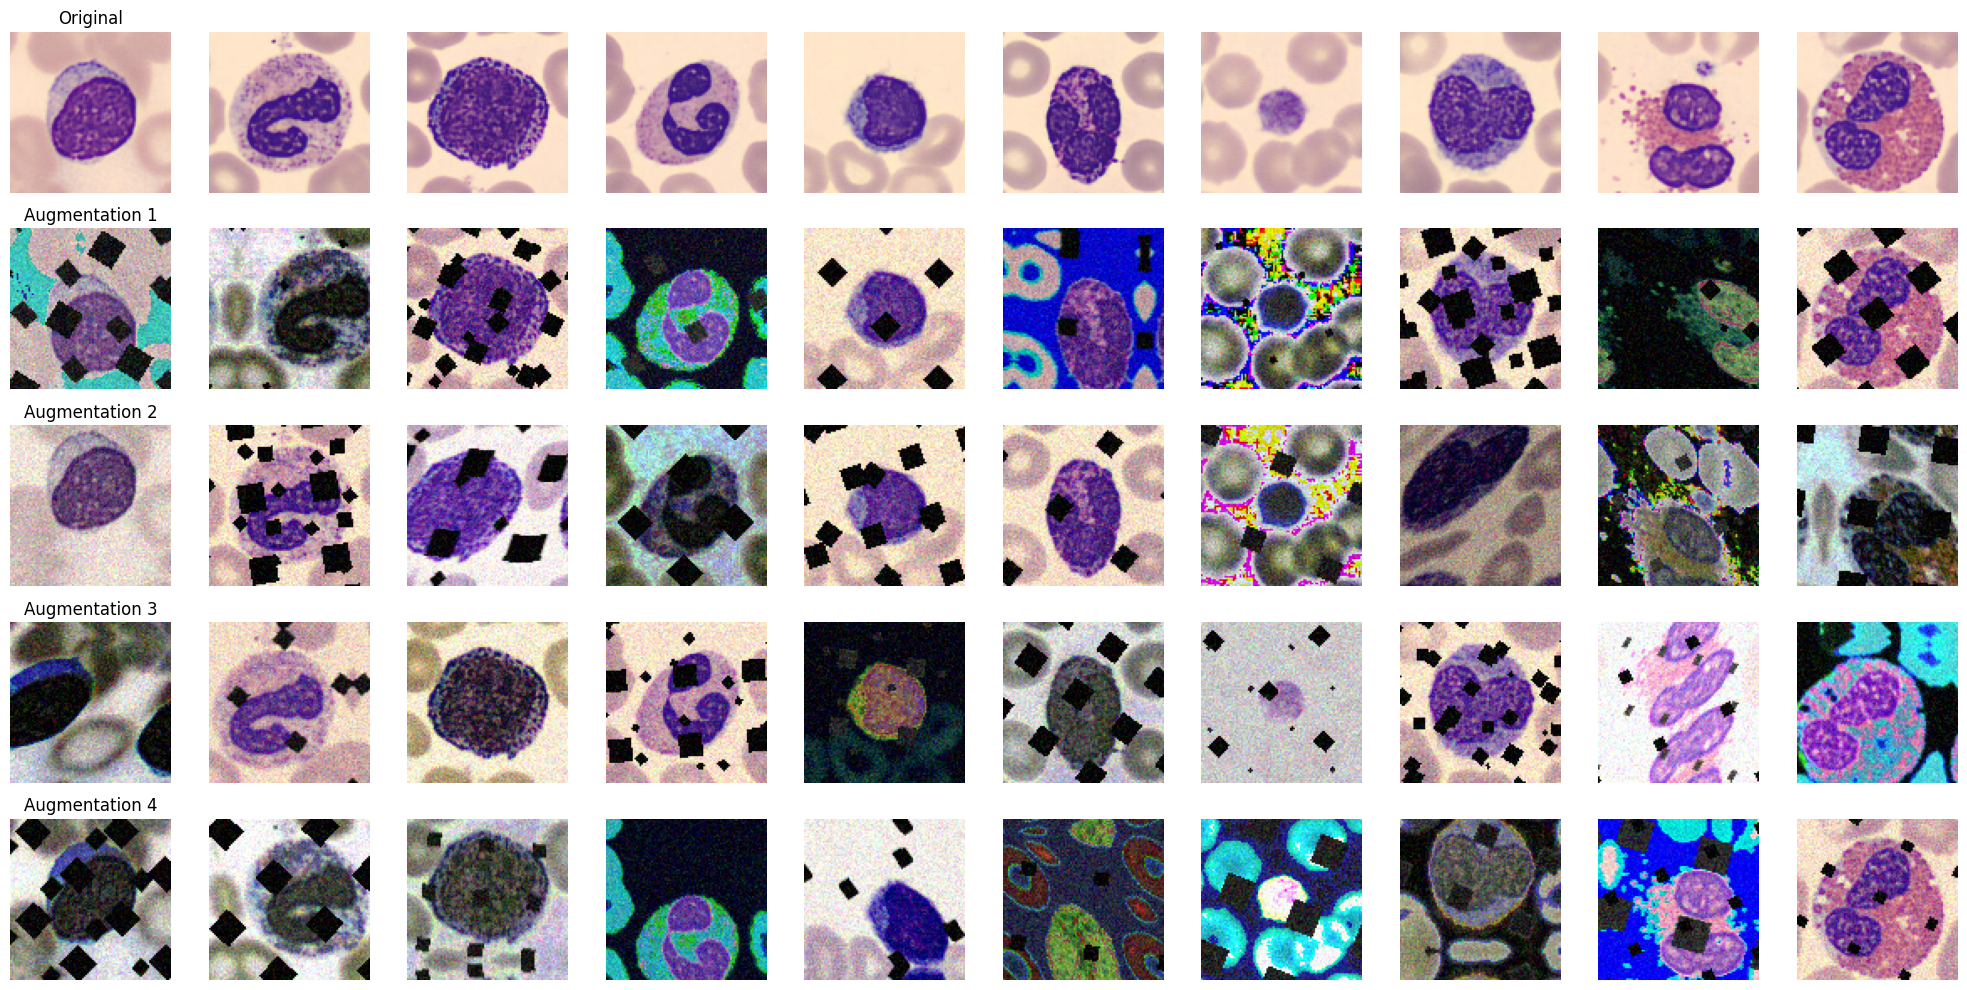

In [ ]:
from preprocessing import plot_augmented_images, create_train_dataset, create_val_dataset 
batch_size = 32
target_size = (224, 224)  # Desired size to feed the MobileNetV2 pre-trained model

plot_augmented_images(X_train, y_train, num_images=10)

train_dataset = create_train_dataset(X_train, y_train, batch_size, target_size)
val_dataset = create_val_dataset(X_val, y_val, batch_size, target_size)

# 5. Training

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

def build_model(input_shape, output_shape, learning_rate, fine_tune_at=30):
    # Loading MobileNetV2 as the base model
    mnv2_model = tfka.MobileNetV2(
        include_top=False, # To define our custom head
        input_shape=input_shape,
        weights="imagenet", # Here the only allowed trained weights in our competition
        alpha=0.75 # Include 75% of the width of the model, so to make the training faster 
    )

    # Custom head for our dataset
    inputs = tfkl.Input(shape=input_shape, name="Input")
    x = mnv2_model(inputs, training=False)
    x = tfkl.GlobalAveragePooling2D(name="global_avg_pool")(x) # Same as in the original MNV2 head
    x = tfkl.Dropout(0.2, name="dropout")(x)  # Low dropout rate for lighter regularization
    outputs = tfkl.Dense(units=output_shape, dtype='float32', activation="softmax", name="softmax")(x)

    model = tfk.Model(inputs, outputs, name="MobileNetV2_pretrained")

    loss = tfk.losses.CategoricalCrossentropy()

    # Applying fine-tuning to unfreeze part of the base model and so to adapt more training weights on our dataset
    mnv2_model.trainable = True  # Unfreeze the whole base model
    for layer in mnv2_model.layers[:-fine_tune_at]:
        layer.trainable = False  # Keep all layers except top fine_tune_at frozen

    # Compiling the model with Lion optimizer
    optimizer = tfk.optimizers.Lion(
        learning_rate=learning_rate,  # Uses our chosen stable starting learning rate for optimization
        beta_1=0.9,  # Momentum parameter to control the contribution of past gradients
        beta_2=0.99,  # Controls the decay rate of the moving average of squared gradients
        weight_decay=1e-4  # Helps prevent overfitting by penalizing large weights; 1e-4 for good balance between convergence stability and speed
    )

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model


In [9]:
for batch_images, batch_labels in train_dataset.take(1):
    print("Train batch images shape:", batch_images.shape)
    print("Train batch labels shape:", batch_labels.shape)
    input_shape = batch_images.shape[1:]
    output_shape = batch_labels.shape[1]
    print("Input Shape:", input_shape)
    print("Output Shape:", output_shape)

initial_learning_rate = 1e-4

model = build_model(input_shape, output_shape, initial_learning_rate)
model.summary()

Train batch images shape: (32, 224, 224, 3)
Train batch labels shape: (32, 8)
Input Shape: (224, 224, 3)
Output Shape: 8


Model: "MobileNetV2_pretrained"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_224            │ (None, 7, 7, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,392,312 (5.31 MB)

 Trainable params: 954,088 (3.64 MB)

 Non-trainable params: 438,224 (1.67 MB)

In [ ]:
epochs = 30 # Setting a limited number of epochs for the incoming early stopping, due to foreseen overfitting

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

In [ ]:
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
    ).history

print("--- %s seconds ---" % (time.time() - start_time))

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model_filename = 'FinalSubmissions/MNV2_pretrained.keras'
print('Saving to', model_filename)
model.save(model_filename)

Epoch 1/30


I0000 00:00:1732225316.419021   90096 service.cc:146] XLA service 0x60ecd8bebff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732225316.419039   90096 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
I0000 00:00:1732225316.449784   90096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 ━━━━━━━━━━━━━━━━━━━━ 65s 157ms/step - accuracy: 0.4712 - loss: 1.4303 - val_accuracy: 0.3668 - val_loss: 4.7328 - learning_rate: 1.0000e-04
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.7296 - loss: 0.7551 - val_accuracy: 0.5538 - val_loss: 2.5713 - learning_rate: 1.0000e-04
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.7637 - loss: 0.6658 - val_accuracy: 0.5277 - val_loss: 2.6880 - learning_rate: 1.0000e-04
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.7820 - loss: 0.6129 - val_accuracy: 0.7335 - val_loss: 1.2085 - learning_rate: 1.0000e-04
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.8018 - loss: 0.5606 - val_accuracy: 0.4692 - val_loss: 3.5244 - learning_rate: 1.0000e-04
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.8160 - loss: 0.5206 - val_accuracy: 0.4180 - val_loss: 2.8538 - learning_rate: 1.0000e-04
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - 

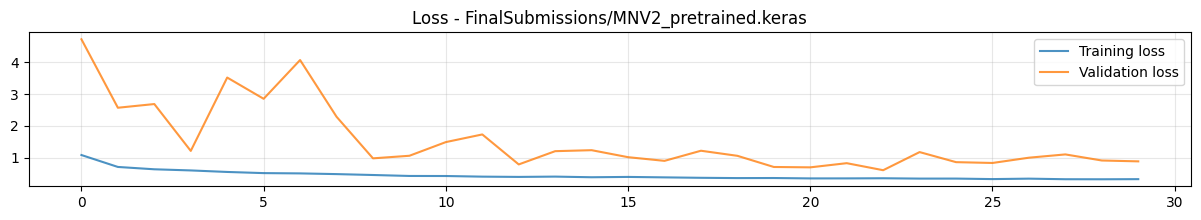

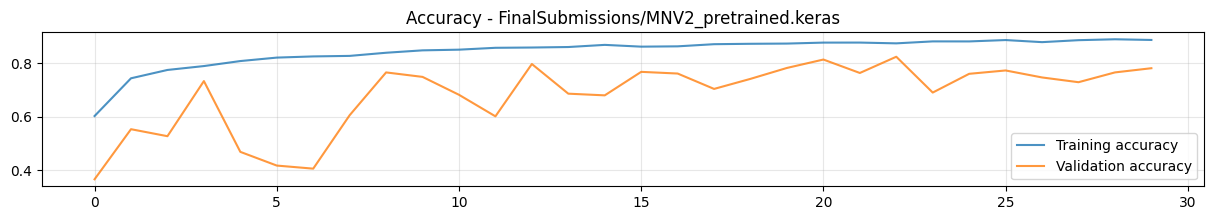

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title(f'Loss - {model_filename}')
plt.legend()
plt.grid(alpha=.3)

plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title(f'Accuracy - {model_filename}')
plt.legend()
plt.grid(alpha=.3)
plt.show()


# 6. Evaluating the model

(2391, 224, 224, 3) (2391, 8)
Predictions Shape: (2391, 8)
Accuracy score over the test set: 0.8218
Precision score over the test set: 0.8683
Recall score over the test set: 0.8218
F1 score over the test set: 0.8231


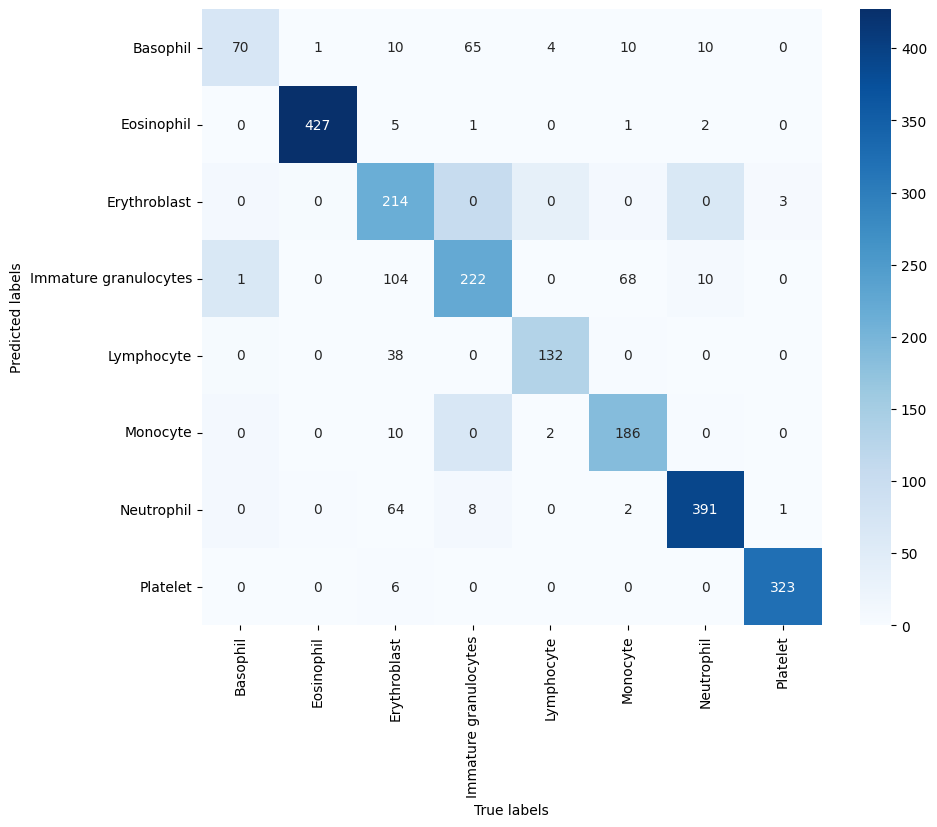

In [ ]:
model = tfk.models.load_model(model_filename)

# Apply normalization and resizing to the test data directly, as done in the model.py submission file
X_normalized = (X_test / 127.5).astype('float32') - 1
X_resized = np.array([cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC) for img in X_normalized])
print(X_resized.shape, y_test.shape)

predictions = model.predict(X_resized, verbose=0)

print("Predictions Shape:", predictions.shape)

pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_test, axis=-1)

accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

cm = confusion_matrix(true_classes, pred_classes)

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()